In [26]:
# Visualización de la matriz de confusión
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# Entrenar un modelo de bosque aleatorio
import joblib
from sklearn.ensemble import RandomForestClassifier
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

In [13]:
# Configuración de rutas de datos
ruta_base = 'data/data_format1/data_format1/'
ruta_train = ruta_base + 'train_format1.csv'
ruta_test = ruta_base + 'test_format1.csv'
ruta_info_usuarios = ruta_base + 'user_info_format1.csv'
ruta_log_usuarios = ruta_base + 'user_log_format1.csv'

# Cargar datos
datos_train = pd.read_csv(ruta_train)
datos_test = pd.read_csv(ruta_test)
info_usuarios = pd.read_csv(ruta_info_usuarios)
log_usuarios = pd.read_csv(ruta_log_usuarios)

# Fusionar y marcar datos de entrenamiento y prueba
datos_train['tipo'] = 'train'
datos_test['tipo'] = 'test'
conjunto_datos = pd.concat([datos_train, datos_test.drop('prob', axis=1)], ignore_index=True)

# Optimizar tipos de datos para reducir uso de memoria
log_usuarios = log_usuarios.astype({
    'user_id': 'int32',
    'item_id': 'int32',
    'cat_id': 'int16',
    'seller_id': 'int16'
})
log_usuarios.rename(columns={'seller_id': 'merchant_id'}, inplace=True)
log_usuarios['brand_id'] = log_usuarios['brand_id'].fillna(0).astype('int16')
log_usuarios['action_type'] = log_usuarios['action_type'].astype('int8')

# Transformar fechas en 'time_stamp' a días transcurridos desde la fecha mínima
fecha_base = pd.to_datetime(log_usuarios['time_stamp'], format='%m%d').min()
log_usuarios['time_stamp'] = (pd.to_datetime(log_usuarios['time_stamp'], format='%m%d') - fecha_base).dt.days
log_usuarios['time_stamp'] = log_usuarios['time_stamp'].astype('int16')

# Imputar valores nulos y ajustar tipos en info_usuarios
info_usuarios['age_range'].fillna(0, inplace=True)
info_usuarios['gender'].fillna(2, inplace=True)
info_usuarios = info_usuarios.astype({'age_range': 'int8', 'gender': 'int8'})

# Codificación de variable categórica 'age_range'
encoder = OneHotEncoder(sparse_output=False)
edad_codificada = encoder.fit_transform(info_usuarios[['age_range']])

# Crear un DataFrame de las columnas codificadas con nombres personalizados para evitar problemas de nombres
nombres_columnas = [f"age_{int(cat)}" for cat in encoder.categories_[0]]
edad_codificada_df = pd.DataFrame(edad_codificada, columns=nombres_columnas)

# Alinear el índice de 'edad_codificada_df' con 'info_usuarios' antes de concatenar
edad_codificada_df.index = info_usuarios.index

# Concatenar las columnas codificadas al DataFrame de info_usuarios
info_usuarios = pd.concat([info_usuarios, edad_codificada_df], axis=1)

C:\Users\lijv1.LINDA_HP\AppData\Local\Temp\ipykernel_26076\2820794715.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  info_usuarios['age_range'].fillna(0, inplace=True)
C:\Users\lijv1.LINDA_HP\AppData\Local\Temp\ipykernel_26076\2820794715.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [14]:
# Agrupar por usuario y calcular características de interacción
user_agg = log_usuarios.groupby('user_id').agg(
    items_distintos=('item_id', 'nunique'),
    categorias_distintas=('cat_id', 'nunique'),
    merchants_distintos=('merchant_id', 'nunique'),
    marcas_distintas=('brand_id', 'nunique'),
    dias_distintos=('time_stamp', 'nunique'),
    dia_max=('time_stamp', 'max'),
    dia_min=('time_stamp', 'min'),
    clicks=('action_type', lambda x: (x == 0).sum()),
    carritos=('action_type', lambda x: (x == 1).sum()),
    compras=('action_type', lambda x: (x == 2).sum()),
    favoritos=('action_type', lambda x: (x == 3).sum())
).reset_index()

In [15]:
# Crear ratios de interacción y otras métricas
user_agg['rango_dias'] = user_agg['dia_max'] - user_agg['dia_min']
user_agg['ratio_clicks'] = user_agg['clicks'] / (user_agg['clicks'] + user_agg['carritos'] + user_agg['compras'] + user_agg['favoritos'] + 1e-10)
user_agg['ratio_compras'] = user_agg['compras'] / (user_agg['clicks'] + user_agg['carritos'] + user_agg['compras'] + user_agg['favoritos'] + 1e-10)

# Integrar información de usuarios y log al conjunto de datos principal
conjunto_datos = conjunto_datos.merge(info_usuarios, on='user_id', how='left').merge(user_agg, on='user_id', how='left')

# Separar los datos de entrenamiento y prueba
datos_entrenamiento = conjunto_datos[conjunto_datos['tipo'] == 'train'].drop(['tipo'], axis=1)
datos_prueba = conjunto_datos[conjunto_datos['tipo'] == 'test'].drop(['tipo'], axis=1)


In [16]:
datos_entrenamiento.head()

,user_id,merchant_id,label,age_range,gender,age_0,age_1,age_2,age_3,age_4,...,dias_distintos,dia_max,dia_min,clicks,carritos,compras,favoritos,rango_dias,ratio_clicks,ratio_compras
0,34176,3906,0.0,6,0,0.0,0.0,0.0,0.0,0.0,...,47,184,10,410,0,34,7,174,0.909091,0.075388
1,34176,121,0.0,6,0,0.0,0.0,0.0,0.0,0.0,...,47,184,10,410,0,34,7,174,0.909091,0.075388
2,34176,4356,1.0,6,0,0.0,0.0,0.0,0.0,0.0,...,47,184,10,410,0,34,7,174,0.909091,0.075388
3,34176,2217,0.0,6,0,0.0,0.0,0.0,0.0,0.0,...,47,184,10,410,0,34,7,174,0.909091,0.075388
4,230784,4818,0.0,0,0,1.0,0.0,0.0,0.0,0.0,...,16,184,21,47,0,7,0,163,0.870370,0.129630


In [17]:
# Crear una lista de transacciones binarizadas para Apriori
def create_transaction(row):
    transaction = []
    if row['clicks'] > 0:
        transaction.append('clicks')
    if row['carritos'] > 0:
        transaction.append('carritos')
    if row['compras'] > 0:
        transaction.append('compras')
    if row['favoritos'] > 0:
        transaction.append('favoritos')
    # Puedes agregar más según lo consideres necesario
    return transaction

# Filtrar sólo los usuarios recurrentes para encontrar patrones en ellos
df_recurrent = datos_entrenamiento[datos_entrenamiento['label'] == 1]
transactions = df_recurrent.apply(create_transaction, axis=1)

In [18]:
# Convertir la lista de transacciones a una matriz binaria
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Ejecutar Apriori con un soporte mínimo
frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)  # Ajusta min_support según tus datos
print(frequent_itemsets)

     support                      itemsets
0   0.064945                    (carritos)
1   0.999687                      (clicks)
2   1.000000                     (compras)
3   0.602871                   (favoritos)
4   0.064945            (clicks, carritos)
5   0.064945           (compras, carritos)
6   0.999687             (compras, clicks)
7   0.602620           (clicks, favoritos)
8   0.602871          (compras, favoritos)
9   0.064945   (compras, clicks, carritos)
10  0.602620  (compras, clicks, favoritos)


In [19]:
# Generar reglas de asociación
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)  # Ajusta el umbral según sea necesario
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Generar nuevas columnas en el dataset con reglas de asociación
for idx, rule in rules.iterrows():
    antecedent = list(rule['antecedents'])[0]
    if antecedent in datos_entrenamiento.columns:
        datos_entrenamiento[f'{antecedent}_rule'] = datos_entrenamiento[antecedent].apply(lambda x: 1 if x > 0 else 0)

             antecedents        consequents   support  confidence      lift
0             (carritos)           (clicks)  0.064945    1.000000  1.000314
1             (carritos)          (compras)  0.064945    1.000000  1.000000
2              (compras)           (clicks)  0.999687    0.999687  1.000000
3               (clicks)          (compras)  0.999687    1.000000  1.000000
4            (favoritos)           (clicks)  0.602620    0.999584  0.999897
5            (favoritos)          (compras)  0.602871    1.000000  1.000000
6    (compras, carritos)           (clicks)  0.064945    1.000000  1.000314
7     (clicks, carritos)          (compras)  0.064945    1.000000  1.000000
8             (carritos)  (compras, clicks)  0.064945    1.000000  1.000314
9   (compras, favoritos)           (clicks)  0.602620    0.999584  0.999897
10   (clicks, favoritos)          (compras)  0.602620    1.000000  1.000000
11           (favoritos)  (compras, clicks)  0.602620    0.999584  0.999897


In [20]:
# Seleccionar las columnas con reglas y otras características que consideres necesarias
X = datos_entrenamiento.drop(['label'], axis=1)
y = datos_entrenamiento['label']

# Dividir en datos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
joblib.dump(clf, 'model_RandomForest_Prueba.joblib')

['model_RandomForest_Prueba.joblib']

In [21]:
from sklearn.metrics import log_loss

# Inicializar el modelo
model = RandomForestClassifier(random_state=42)

# Número de árboles
n_estimators = 100
train_losses = []
val_losses = []

# Entrenar el modelo incrementando el número de árboles
for n in range(1, n_estimators + 1):
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)

    # Obtener las probabilidades de predicción
    y_train_pred_proba = model.predict_proba(X_train)
    y_val_pred_proba = model.predict_proba(X_val)

    # Calcular el log loss
    train_loss = log_loss(y_train, y_train_pred_proba)
    val_loss = log_loss(y_val, y_val_pred_proba)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

NameError: name 'clf' is not defined

In [22]:
joblib.dump(model, 'model_RandomForest_Loss.joblib')

['model_RandomForest_Loss.joblib']

In [23]:
clf_cargado = joblib.load('model_RandomForest_Loss.joblib')

In [27]:
y_pred = clf_cargado.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.9326854886627183
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     49026
         1.0       0.08      0.01      0.02      3147

    accuracy                           0.93     52173
   macro avg       0.51      0.50      0.49     52173
weighted avg       0.89      0.93      0.91     52173



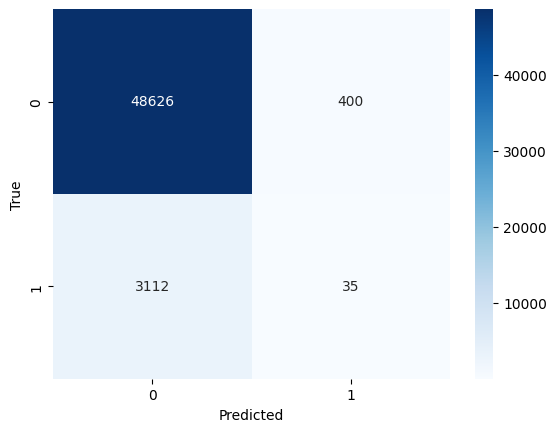

In [28]:
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

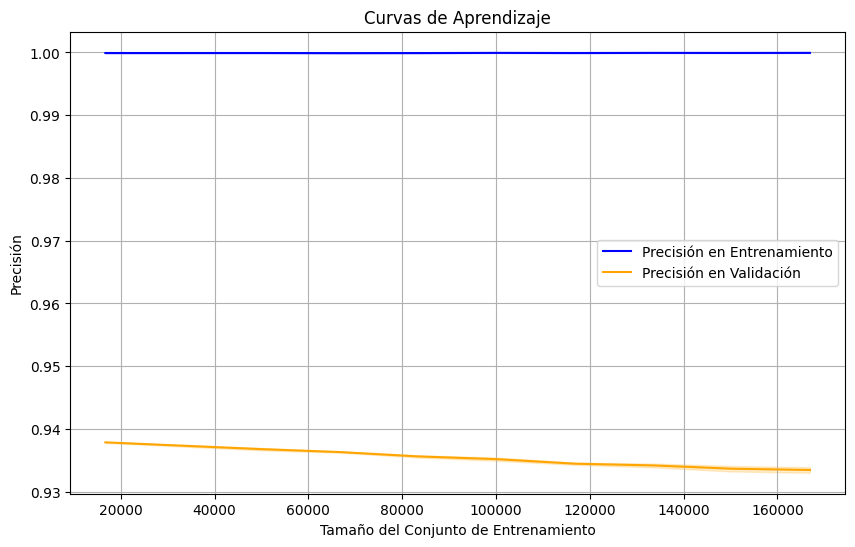

In [38]:
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Promedio y desviación estándar para los puntajes de entrenamiento y validación
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Precisión en Entrenamiento', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_mean, label='Precisión en Validación', color='orange')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)

plt.title('Curvas de Aprendizaje')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()


In [31]:
# Generar las puntuaciones de probabilidad para ambas clases
y_scores = model.predict_proba(X_val)  # Probabilidades para ambas clases



In [32]:
fpr1, tpr1, _ = roc_curve(y_val, y_scores[:, 1])
roc_auc1 = auc(fpr1, tpr1)

# Calcular la curva ROC para la clase 0
fpr0, tpr0, _ = roc_curve(y_val, y_scores[:, 0])
roc_auc0 = auc(fpr0, tpr0)


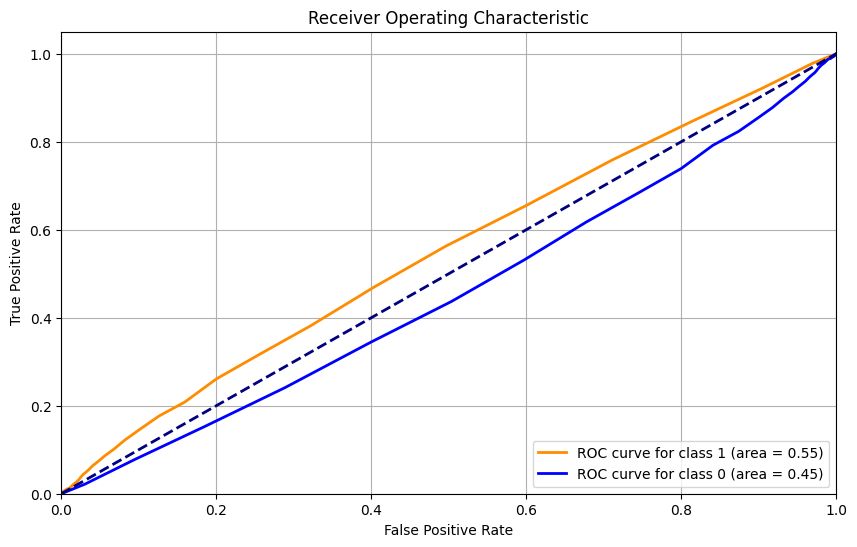

In [33]:
# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve for class 1 (area = %0.2f)' % roc_auc1)
plt.plot(fpr0, tpr0, color='blue', lw=2, label='ROC curve for class 0 (area = %0.2f)' % roc_auc0)

# Graficar la línea de referencia
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [36]:
# Calcular la curva Precision-Recall para la clase 1
precision1, recall1, _ = precision_recall_curve(y_val, y_scores[:, 1])
avg_precision1 = average_precision_score(y_val, y_scores[:, 1])

# Calcular la curva Precision-Recall para la clase 0 (tratando 0 como positiva)
y_scores0 = model.predict_proba(X_val)[:, 0]  # Probabilidades de la clase 0
precision0, recall0, _ = precision_recall_curve(y_val, y_scores0)
avg_precision0 = average_precision_score(y_val, y_scores0)


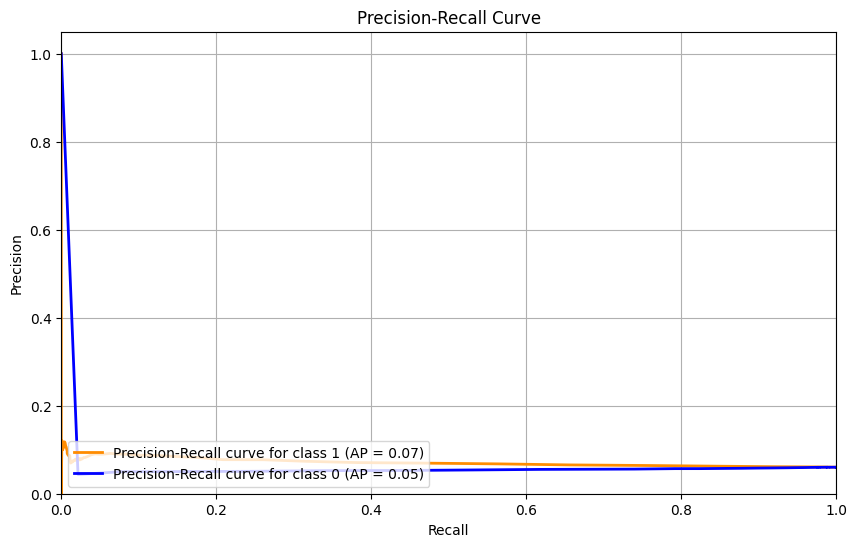

In [37]:
# Graficar la curva Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(recall1, precision1, color='darkorange', lw=2, label='Precision-Recall curve for class 1 (AP = %0.2f)' % avg_precision1)
plt.plot(recall0, precision0, color='blue', lw=2, label='Precision-Recall curve for class 0 (AP = %0.2f)' % avg_precision0)

# Configuración del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


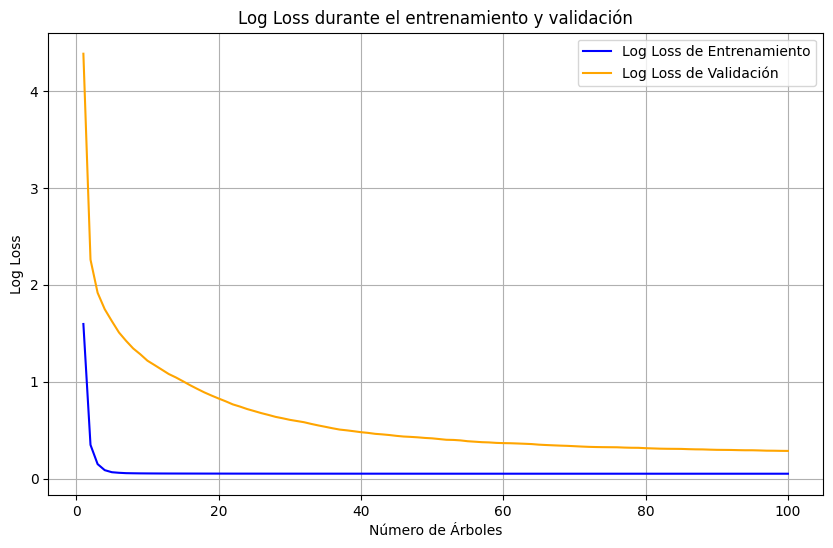

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators + 1), train_losses, label='Log Loss de Entrenamiento', color='blue')
plt.plot(range(1, n_estimators + 1), val_losses, label='Log Loss de Validación', color='orange')
plt.title('Log Loss durante el entrenamiento y validación')
plt.xlabel('Número de Árboles')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()
plt.show()
